In [130]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
import matplotlib
import missingno as msno 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [92]:
# Author: John Lee 
# This notebook is to perform EDA on LoL dataset available from Kaggle
# URL for the dataset: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

import warnings
warnings.filterwarnings('ignore')
# Load Dataset
wDir = os.getcwd()
df = pd.read_csv(os.path.join(wDir, 'high_diamond_ranked_10min.csv'))

# Exploratory Data Analysis & Visualization

In [ ]:
def data_init(df):
    print('Displaying columns:')
    print(df.columns)
    print('Checking Stats:')
    print(df.describe())
    print('Done!')
    print('Checking for nulls:')
    msno.bar(df)

In [64]:
def get_teams_cols(df):
    blue = [c for c in df.columns if 'blue' in c]
    red = [c for c in df.columns if 'red' in c]
    return blue, red

In [56]:
# Do bivariate analysis between features to observe correlations. An user can set an interval for pairplot
# By default interval is 5. An user can change this value to view more features in a pairplot

def bivariate_vis(df, interval = 5):
    idx = np.arange(0, df.shape[1], interval)
    
    for i, e in enumerate(idx):
        if i == 0:
            print(f'Processing column 0 to {idx[i+1]-1}')
            tmp = df.iloc[:,:idx[i+1]]
        elif i == len(idx)-1:
            print(f'Processing column {e} to {df.shape[1]-1}')
            tmp = df.iloc[:,e:]
        else:
            print(f'Processing colum {idx[i]} to {idx[i+1]-1}')
            tmp = df.iloc[:, idx[i]:idx[i+1]]
            
        if 'blueWins' not in tmp.columns:
            tmp['blueWins'] = df['blueWins']
        
        g = sns.PairGrid(data=tmp, vars=tmp.columns, hue='blueWins', height=3, palette='Set2')
        g = g.map_diag(plt.hist)
        g = g.map_offdiag(plt.scatter)
        g.add_legend();

In [72]:
def corr_mat(df):
    cm = df.corr().abs()
    lower_tri = cm.where(np.tril(np.ones(b_cor_matrix.shape),k=1).astype(np.bool))
    return lower_tri

In [76]:
# Displaying 2 heatmaps; 1 for red team, 1 for blue, due to the matrix being too big

def heatmap_vis(df, dtype = 'features'):
    if dtype == 'features':
        b_col, r_col = get_teams_cols(df)
        blue = df[b_col]
        red = df[r_col]

        plt.figure(figsize = (16,12))
        b_lower_tri = corr_mat(blue.drop('blueWins', axis = 1))
        sns.heatmap(b_lower_tri, annot = True, cmap="YlGnBu")

        plt.figure(figsize = (16,12))
        r_lower_tri = corr_mat(red)
        sns.heatmap(r_lower_tri, annot = True, cmap = 'Reds')
    
    else:
        fig = plt.figure(figsize= (4,10))
        sns.heatmap(df.corr()[['blueWins']].sort_values(by = 'blueWins', ascending = False),annot = True)

# Data Preparation

In [117]:
# Process and Prepare the data

def data_prep(df):
    # delete gameID, which is just index and unrelated
    out = df.copy()
    del out['gameId']
    # separate X and y
    y = out['blueWins']
    X = out.drop('blueWins', axis = 1)
    return X, y
    

In [75]:
# Function to drop highly correlated variables. Threshold is set to 0.8 by default, but an user can change this.

def drop_high_corr_col(df, threshold = 0.8):
    lower_tri = corr_mat(df)
    to_drop = [c for c in lower_tri.columns if any(lower_tri[c] > 0.8)]
    out = df.drop(to_drop, axis = 1)
    return out

In [78]:
# RMSE score evaluation Function

def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [142]:
# Feature Selection with Elastic Net

def fs_enet(df, plot = True):
    X, y = data_prep(df)
    # Choose matrix of alphas and l1-ratios for grid search
    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1]
    l1_ratios = [1, 0.9, 0.8, 0.7, 0.5, 0.1]
    
    # Elastic Net Grid search to find best performing parameters
    cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio = l1_ratio), X, y).mean() 
                for (alpha, l1_ratio) in product(alphas, l1_ratios)]
    
    # Find the alpha-l1_ratio where rmse is the minimum
    idx = list(product(alphas, l1_ratios))
    m_idx = cv_elastic.index(min(cv_elastic))
    alpha, l1_ratio = idx[m_idx]
    
    # Fit the model
    elastic = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
    elastic.fit(X, y)
    
    # Layout the features based on the importance and visualize.
    cf = pd.Series(elastic.coef_, index = X.columns)
    imp_cf = pd.concat([cf.sort_values().head(10), cf.sort_values().tail(10)])
    print("Elastic Net picked " + str(sum(cf != 0)) + " variables and eliminated the other " +  str(sum(cf == 0)) + " variables")
    
    if plot:
        # Plot out validation curve
        plt.figure(figsize=(12, 6))
        p_cv_elastic = pd.Series(cv_elastic, index = idx)
        p_cv_elastic = p_cv_elastic.dropna()
        p_cv_elastic.plot(title = "Validation - Elastic Net")
        plt.xlabel("alpha - l1_ratio")
        plt.ylabel("rmse")

        # Layout all coeff
        plt.figure(figsize=(8, 10))
        cf.sort_values().plot(kind = "barh", color = '#f5bc42')
        plt.title("All Coefficients in the Elastic Net Model")

        # Layout 20 most important 
        plt.figure(figsize=(8, 10))
        imp_cf.plot(kind = "barh")
        plt.title("20 Important Coefficients in the Elastic Net Model")
    
        return list(imp_cf.index)
    else:
        return list(imp_cf.index)

In [145]:
def finalize_data(df):
    imp_cf = fs_enet(df)
    X, y = data_prep(df)
    X_out = X[imp_cf]
    final_df = pd.concat([X_out, y], axis = 1)
    return final_df

Elastic Net picked 32 variables and eliminated the other 6 variables


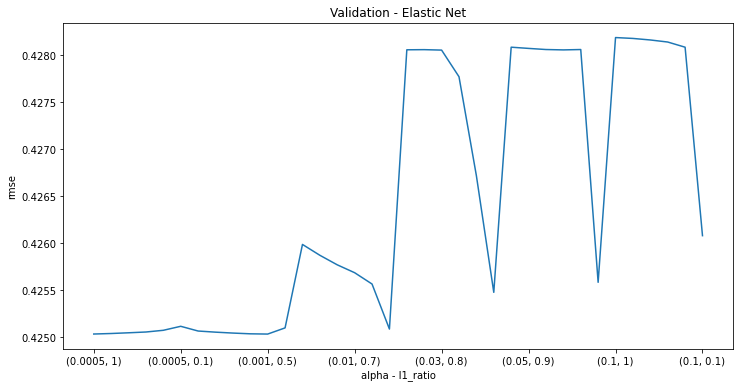

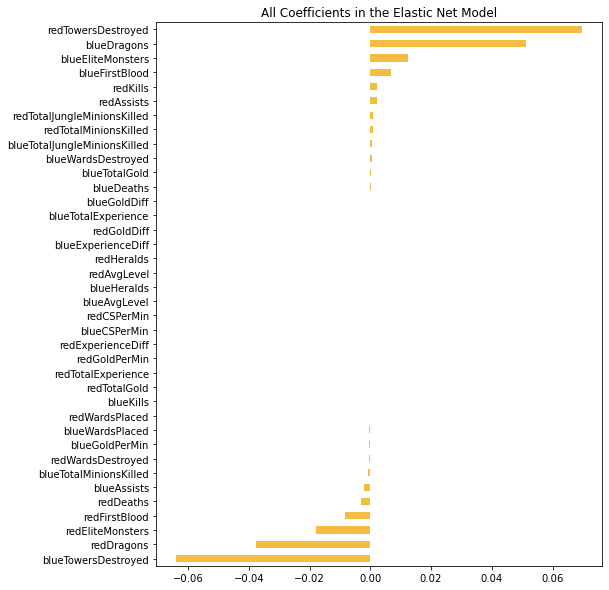

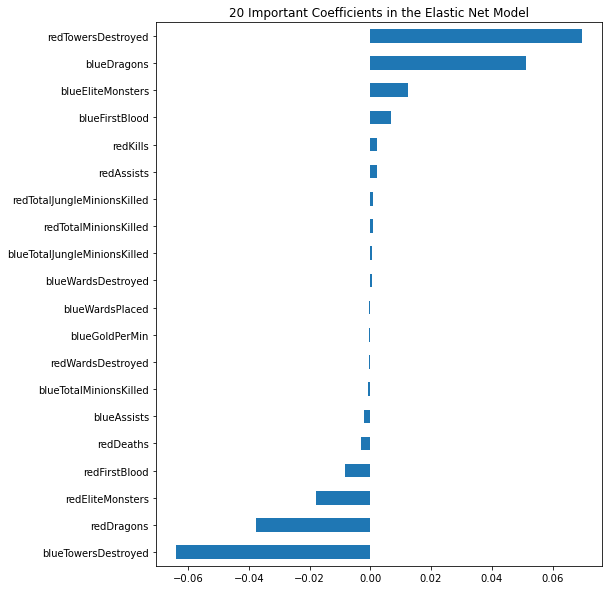

In [146]:
final_df = finalize_data(df)
final_df.to_csv('cleaned_df.csv', index = False)